In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yfinance as yf
from pandas_datareader import data as pdr
import requests
import datetime
import io
import os, contextlib
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, add_changepoints_to_plot

## Data fetching

In [2]:
#Fetch the stocks we are interested 
tickers = ['IYM', 'IYK','IYE','IYG','IYH','IYJ','IYW','IYZ','IDU']

data = pdr.DataReader(tickers, data_source='yahoo', start='2019-01-01', end='2021-06-22')

data = data['Close']

data.rename(columns={"IYM": "Basic Materials", "IYK": "Consumer Goods", "IYE": "Energy", "IYG": "Financial Services", "IYH": "Healthcare", "IYJ": "Industrial", "IYW":"Technology", "IYZ": "Telecommunications", "IDU": "Utilities"},inplace=True)

data.to_csv('data_close.csv')

data.head()

Symbols,Basic Materials,Consumer Goods,Energy,Financial Services,Healthcare,Industrial,Technology,Telecommunications,Utilities
Date,,,,,,,,,
2019-01-02,84.570000,106.209999,31.820000,113.730003,178.330002,64.415001,40.070000,26.549999,65.820000
2019-01-03,82.059998,104.870003,31.510000,111.550003,174.360001,62.560001,38.215000,26.139999,65.930000
2019-01-04,85.440002,107.809998,32.669998,115.690002,179.830002,64.934998,39.952499,26.940001,66.885002
2019-01-07,85.559998,108.269997,33.180000,116.180000,181.240005,65.394997,40.290001,27.320000,66.449997
2019-01-08,86.610001,109.580002,33.480000,116.400002,183.080002,66.449997,40.737499,27.740000,67.290001


In [68]:
#Create plot of the ETFs prices
import plotly.express as px

px.line(data,width=1280,height=720,title='ETF price')



In [69]:
#Create everage of all ETFs
data_average = data.mean(axis=1)

px.line(data_average,width=1280,height=720,title='Averaged ETFs prices')

In [71]:
#Plot mean in addition with a few stock prices
data['Average'] = data.mean(axis=1)

px.line(data,y=['Consumer Goods','Healthcare','Average'],title='Comparison between ETFs and the average')

In [80]:
#Plot the graph of returns
change = data.pct_change()

change.drop(columns='Average',inplace=True)

px.line(change, title='Returns of ETFs',width=1280,height=720)

In [62]:
#Plot histograms of pct_change
for i in change.columns:
    plt.figure()
    fig = px.histogram(change[i],nbins=100)
    fig.show()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [79]:
#Plot the cumulative returns
fig = plt.figure()
cumsum = ((change + 1).cumprod() -1)
px.line(cumsum,width=1280,height=720,title='Cumulative returns of ETFs')

<Figure size 432x288 with 0 Axes>

In [78]:
#Compute traling volatility for all ETFs (60 days window)
volatility = change.rolling(window=60).std()*np.sqrt(60)
px.line(volatility,title='Trailing volatility - 60 days window',width=1280,height=720)

In [ ]:
#Compute annualized volatility for all ETFs

In [12]:
#Create new dataframes (for the selected ETFs) in order to perform forecasting

healthcare = pd.DataFrame(data.loc[:,'Healthcare'])

healthcare.reset_index(inplace=True)

healthcare.rename(columns={'Date':'ds','Healthcare':'y'},inplace=True)


In [31]:
#Use facebook prophet API (80% confidence interval)

#Create the model
m = Prophet()
m.fit(healthcare)

#Create future datapoints (dates)
future = m.make_future_dataframe(periods=365)
future.tail()

#Perform forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = plot_plotly(m,forecast)

fig1.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
#Plot components
fig2 = plot_components_plotly(m,forecast)
fig2.show()

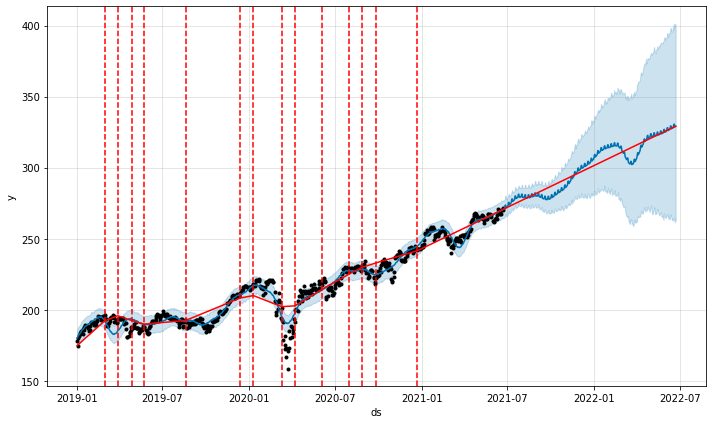

In [32]:
#Plot the changing points
fig = m.plot(forecast)
delta = add_changepoints_to_plot(fig.gca(),m,forecast)

In [119]:
'''
#Create new dataframe for facebook prophet

from kats.consts import TimeSeriesData

healthcare = pd.DataFrame(data.loc[:,'Healthcare'])

healthcare.reset_index(inplace=True)

healthcare.rename(columns={'Date':'time','Healthcare':'value'},inplace=True)

healthcare = TimeSeriesData(healthcare)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


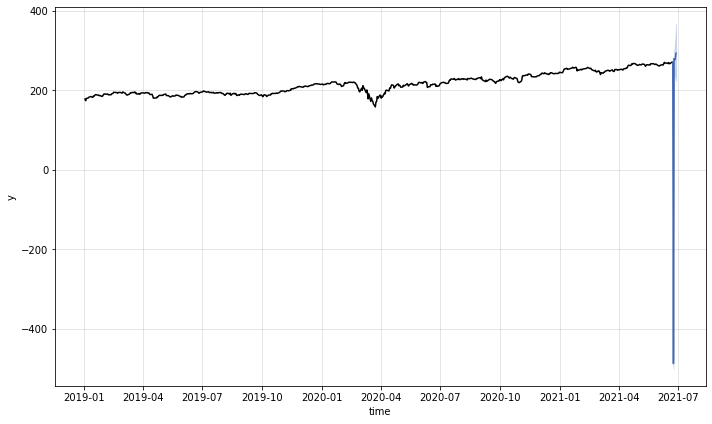

In [120]:
'''
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(healthcare, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=6, freq="MS")

# plot to visualize
m.plot()

AttributeError: 'TimeSeriesData' object has no attribute 'head'

In [2]:
'''
#Set start and end time
start = datetime.datetime(2019,1,1)

end = datetime.datetime(2021,6,21)

In [3]:
'''
#Get the name of all listed companies
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"

s = requests.get(url).content

companies = pd.read_csv(io.StringIO(s.decode('utf-8')))

Symbols = companies['Symbol'].tolist()

In [9]:
'''
#Download the data

# create empty dataframe
stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

this date range, symbol may be delisted
1103 : FXENP,
1 Failed download:
- FXENP: No data found, symbol may be delisted
1104 : GABC,1105 : GAI,1106 : GAIA,1107 : GAIN,1108 : GAINO,
1 Failed download:
- GAINO: No data found, symbol may be delisted
1109 : GAINP,
1 Failed download:
- GAINP: No data found, symbol may be delisted
1110 : GALE,1111 : GALT,1112 : GALTU,
1 Failed download:
- GALTU: No data found, symbol may be delisted
1113 : GALTW,
1 Failed download:
- GALTW: No data found, symbol may be delisted
1114 : GAME,1115 : GARS,
1 Failed download:
- GARS: No data found, symbol may be delisted
1116 : GASS,1117 : GBCI,1118 : GBDC,1119 : GBIM,1120 : GBLI,1121 : GBNK,1122 : GBSN,
1 Failed download:
- GBSN: No data found for this date range, symbol may be delisted
1123 : GCBC,1124 : GCVRZ,
1 Failed download:
- GCVRZ: No data found, symbol may be delisted
1125 : GDEF,
1 Failed download:
- GDEF: No data found for this date range, symbol may be delisted
1126 : GENC,1127 : GENE,1128 : GEOS,112

KeyboardInterrupt: 

In [5]:
'''
#Get all tickers from NASDAQ

n_tickers = pd.read_csv('/Users/romeoleon/Downloads/nasdaqtraded.csv',sep='|')

n_tickers = n_tickers['Symbol']


In [22]:
'''
stocks = ['IYH']
for stock in stocks:
    x = yf.Ticker(stock)
    info = x.history(period="2y")
    print(info)

                  Open        High         Low       Close  Volume  Dividends  \
Date                                                                            
2019-06-24  192.073235  192.073235  190.951888  191.458939   89000        0.0   
2019-06-25  191.653972  192.122011  190.259586  190.415604   65000        0.0   
2019-06-26  190.483851  190.483851  187.782848  188.133881   40800        0.0   
2019-06-27  188.650665  189.840276  188.650665  189.430740   22300        0.0   
2019-06-28  189.596511  190.600853  188.787185  190.405838   43000        0.0   
...                ...         ...         ...         ...     ...        ...   
2021-06-17  267.179993  270.670013  267.179993  269.890015   15000        0.0   
2021-06-18  268.109985  268.250000  266.920013  267.250000   37100        0.0   
2021-06-21  267.839996  270.630005  267.070007  270.440002   96400        0.0   
2021-06-22  270.500000  271.470001  269.720001  271.329987   28600        0.0   
2021-06-23  270.820007  270.

## Data exploration

## Data cleaning

## ----------------------------------------------------------------

In [ ]:
! rmdir hist